# **Entrenamiento de una red neuronal convolucional**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
import pickle
import cv2
from PIL import Image
import tensorflow as tf
from skimage.transform import resize
from skimage.exposure import histogram, cumulative_distribution, equalize_hist
from skimage.io import imread 
from skimage import io
from skimage.transform import rotate
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model

import tensorflow_addons
from tensorflow_addons.metrics import F1Score, CohenKappa

In [4]:
%cd drive/MyDrive/pucp/ciclo_05/comp_graf
!unzip train_full.zip -d ../../../../..
%cd ../../../../..
!cp drive/MyDrive/pucp/ciclo_05/comp_graf/dataset_full.csv dataset_full.csv

Streaming output truncated to the last 5000 lines.
  inflating: ../../../../../train/d748adca7e034f5203e7cc99deb1e458_right.jpg  
  inflating: ../../../../../train/d74a214501c1c40b2c77e995082f3587_left.jpg  
  inflating: ../../../../../train/d74a214501c1c40b2c77e995082f3587_right.jpg  
  inflating: ../../../../../train/d7524e44b42e52a688f6b5cc14bb3006_left.jpg  
  inflating: ../../../../../train/d7524e44b42e52a688f6b5cc14bb3006_right.jpg  
  inflating: ../../../../../train/d7528f9dcfa7877af9e4f86af207c469_left.jpg  
  inflating: ../../../../../train/d7528f9dcfa7877af9e4f86af207c469_right.jpg  
  inflating: ../../../../../train/d754f7302ec0da60aeb079c36b4938d4_left.jpg  
  inflating: ../../../../../train/d754f7302ec0da60aeb079c36b4938d4_right.jpg  
  inflating: ../../../../../train/d75741b309bf39d3ef6be3b23990eeaf_left.jpg  
  inflating: ../../../../../train/d75741b309bf39d3ef6be3b23990eeaf_right.jpg  
  inflating: ../../../../../train/d759175de8ea5b1d9a2660e45554894f_left.jpg  
  infla

### Preprocesamiento

In [ ]:
df = pd.read_csv('data/train.csv')
df["eye"] = df["location"].apply(lambda x: 0 if x == "left" else 1)
df["path"] = df.apply(lambda x: "data/train/{}_{}.jpg".format(x["ID"], x["location"]), axis=1)
df.head()

### Distribución de los datos

In [ ]:
df[['level', 'eye']].hist(figsize = (10, 5))

In [ ]:
# Contar la cantidad de datos por level
df.groupby("level").count()

## Data augmentation

In [ ]:
def rotate_images(image_path, degrees_of_rotation):
    image = io.imread(image_path)
    image = rotate(image, degrees_of_rotation)
    image_path_n = image_path.split(".")[0] + "_" + str(degrees_of_rotation) + ".jpg"
    io.imsave(image_path_n, image)

def mirror_images(image_path):
    image = cv2.imread(image_path)
    image = cv2.flip(image, 1)
    image_path_n = image_path.split(".")[0] + "_mir" + ".jpg"
    cv2.imwrite(image_path_n, image)

In [ ]:
# 3400 para cada clase
# para clase 0, escoger aleatoriamente 3400
# para clase 1, escoger aleatoriamente 1700 y rotar 180 1700
# para clase 2, escoger aleatoriamente 3400
# para clase 3, rotar 90, 120, 180, 270 | mirror al total y escoger aleatoriamente de 3400 
# para clase 4, rotar 90, 120, 180, 210, 270 | mirror al total y escoger aleatoriamente de 3400

# df[df["level"]==1].apply(lambda x: rotate_images(x.path, 90), axis=1)
# df[df["level"]==3].apply(lambda x: rotate_images(x.path, 90), axis=1)
# df[df["level"]==3].apply(lambda x: rotate_images(x.path, 120), axis=1)
# df[df["level"]==3].apply(lambda x: rotate_images(x.path, 180), axis=1)
# df[df["level"]==3].apply(lambda x: rotate_images(x.path, 270), axis=1)
# df[df["level"]==3].apply(lambda x: mirror_images(x.path), axis=1)
# df[df["level"]==4].apply(lambda x: rotate_images(x.path, 90), axis=1)
# df[df["level"]==4].apply(lambda x: rotate_images(x.path, 120), axis=1)
# df[df["level"]==4].apply(lambda x: rotate_images(x.path, 180), axis=1)
# df[df["level"]==4].apply(lambda x: rotate_images(x.path, 210), axis=1)
# df[df["level"]==4].apply(lambda x: rotate_images(x.path, 270), axis=1)
# df[df["level"]==4].apply(lambda x: mirror_images(x.path), axis=1)

In [ ]:
# Guardando nuevas imagenes en df
names = df["path"].to_list()
id_list = []
path_list = []
location_list = []
for row in os.listdir("data/train"):
    path_temp = "data/train/" + row
    if path_temp not in names:
        path_list.append(path_temp)
        id_list.append(row.split(".")[0].split("_")[0])
        location_list.append(row.split(".")[0].split("_")[1])

In [ ]:
df_new = pd.DataFrame({"ID": id_list, "location": location_list, "level": "", "eye": "", "path": path_list})

In [ ]:
df_new2 = pd.merge(df_new, df, how='left',on=['ID', 'location'])
df_new2 = df_new2[["ID", "location", "level_y", 'eye_y', "path_x"]]
df_new2.rename(columns = {'level_y':'level', 'eye_y':'eye', 'path_x':'path'}, inplace = True)

In [ ]:
df_full = df.append(df_new2)
df_full.to_csv("data/dataset_full.csv")

In [ ]:
df = pd.read_csv("data/dataset_full.csv")
df_0 = df[df["level"]==0].sample(2000)
df_1 = df[df["level"]==1].sample(2000)
df_2 = df[df["level"]==2].sample(2000)
df_3 = df[df["level"]==3].sample(2000)
df_4 = df[df["level"]==4].sample(2000)
dataset_balanced = df_0.append(df_1).append(df_2).append(df_3).append(df_4)
dataset_balanced.to_csv("data/dataset_bal.csv")

## Cargando dataset balanceado

In [5]:
df = pd.read_csv("dataset_full.csv")
df_0 = df[df["level"]==0].sample(3400)
df_1 = df[df["level"]==1].sample(3400)
df_2 = df[df["level"]==2].sample(3400)
df_3 = df[df["level"]==3].sample(3400)
df_4 = df[df["level"]==4].sample(3400)
dataset_balanced = df_0.append(df_1).append(df_2).append(df_3).append(df_4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd660457590>,
      dtype=object)

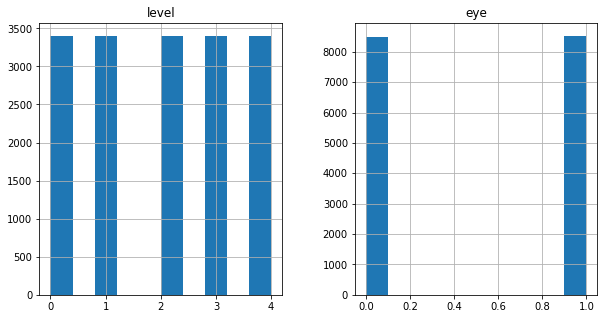

In [6]:
df = dataset_balanced
df["level_str"] = df["level"].apply(lambda x: str(x))
df["path"] = df["path"].apply(lambda x: x.replace("data/",""))
df["path_n"] = df["path"].apply(lambda x: x.split("/")[1])
df[['level', 'eye']].hist(figsize = (10, 5))

### Split data en entrenamiento y validacion

In [7]:
train, val = train_test_split(df, test_size=0.20, random_state=42, stratify = df['level'])

### Balanceo de datos en el dataset de entrenamiento

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd660393dd0>,
      dtype=object)

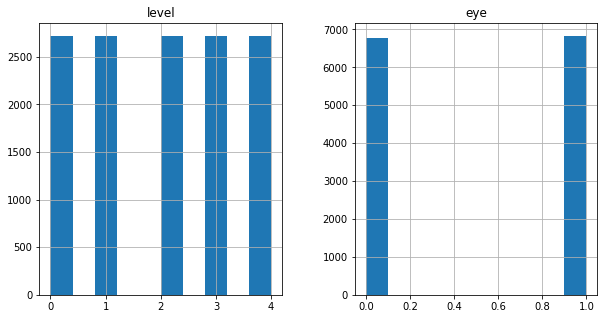

In [8]:
# train_df = df.groupby(['level', 'eye']).apply(lambda x: x.sample(1500, replace = True)).reset_index(drop = True)
# print('New Data Size:', train_df.shape[0], 'Old Size:', train.shape[0])
train[['level', 'eye']].hist(figsize = (10, 5))

### Funciones

In [9]:
src_dir = 'train'
train_dir = 'data/train_n'
for index, row in train.iterrows():
    srcfile = row["path"]
    dstfile = os.path.join(train_dir, str(row['level']))
    os.makedirs(dstfile, exist_ok=True)
    shutil.copy(srcfile, dstfile)

src_dir = 'train'
val_dir = 'data/val_n'
for index, row in val.iterrows():
    srcfile = srcfile = row["path"]
    dstfile = os.path.join(val_dir, str(row['level']))
    os.makedirs(dstfile, exist_ok=True)
    shutil.copy(srcfile, dstfile)

In [10]:
from skimage import exposure

IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
CHANNELS = 3

train_path = "data/train_n"
val_path = "data/val_n"
BATCH_SIZE = 20

train_batches = ImageDataGenerator(rescale=1./128# ,preprocessing_function=preprocess_image_3
                                    ).flow_from_directory(
                                        train_path, 
                                        target_size=IMG_SIZE, 
                                        color_mode="rgb", 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

val_batches = ImageDataGenerator(rescale=1./128# ,preprocessing_function=preprocess_image_3
                                    ).flow_from_directory(
                                        val_path, 
                                        target_size=IMG_SIZE, 
                                        color_mode="rgb", 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

# test_path = "data/test_n"
# test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 13600 images belonging to 5 classes.
Found 3400 images belonging to 5 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 1. 0. 0. 0.]


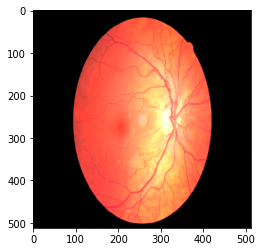

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 1. 0. 0. 0.]


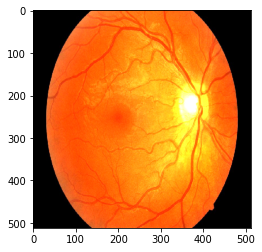

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0. 0. 0. 0.]


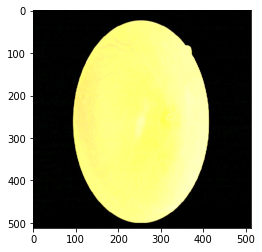

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 1. 0. 0.]


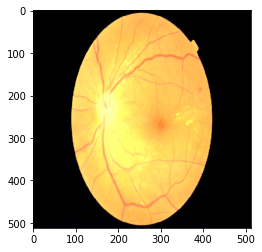

In [11]:
from keras.preprocessing import image
x,y = train_batches.next()
for i in range(0,4):
    # print(x[i])
    image=x[i]
    label=y[i]
    print(label)
    plt.imshow(image)
    plt.show()

## Parte olvidada

In [ ]:
nb_filters = 32
model = tf.keras.Sequential([
    Conv2D(nb_filters, (8, 8), padding='valid', strides=4, input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS)),
    Activation('relu'),

    Conv2D(nb_filters, (8, 8)),
    Activation('relu'),

    Conv2D(nb_filters, (8, 8)),
    Activation('relu'),

    MaxPool2D(pool_size=(2,2)),

    Conv2D(64, (16, 16)),
    Activation('relu'),

    MaxPool2D(pool_size=(2,2)),

    Flatten(),

    Dense(128),
    Activation('sigmoid'),
    Dropout(0.25),

    Dense(5),
    Activation('softmax')
])

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy", # tf.keras.losses.BinaryCrossentropy()
              metrics=['acc','AUC', tensorflow_addons.metrics.F1Score(num_classes=5, average='weighted'),tensorflow_addons.metrics.CohenKappa(num_classes=5)])

stop = EarlyStopping(monitor='val_acc', 
                    min_delta=0.001,
                    patience=2,
                    verbose=0,
                    mode='auto')

In [ ]:
history = model.fit(train_batches,
                    epochs=20,
                    verbose=1,
                    validation_data=val_batches,
                    callbacks=[stop])

In [ ]:
# Save model and history
model.save('model_nuevo.h5')
with open('history_nuevo.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
# acc = model.evaluate_generator(test_batches, verbose=1)
# print("Accuracy: ", acc[1])

In [ ]:
with open('history_n.pkl', 'rb') as file_pi:
    history1 = pickle.load(file_pi)
    file_pi.close()

with open('history_n2.pkl', 'rb') as file_pi:
    history2 = pickle.load(file_pi)
    file_pi.close()

with open('history_n3.pkl', 'rb') as file_pi:
    history3 = pickle.load(file_pi)
    file_pi.close()

with open('history_n4.pkl', 'rb') as file_pi:
    history4 = pickle.load(file_pi)
    file_pi.close()

In [ ]:
acc = history1["acc"] + history2["acc"] + history3["acc"] + history4["acc"]
val_acc = history1["val_acc"] + history2["val_acc"] + history3["val_acc"] + history4["val_acc"]
loss = history1["loss"] + history2["loss"] + history3["loss"] + history4["loss"]
val_loss = history1["val_loss"] + history2["val_loss"] + history3["val_loss"] + history4["val_loss"]

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

In [ ]:
pred = model.predict(test_batches)

In [ ]:
pd.DataFrame(pred)

In [ ]:
pred_n = np.argmax(pred, axis=1)

In [ ]:
df_test["level_n"] = pred_n

In [ ]:
df_test.to_csv("submission_n.csv", index=False)

In [ ]:
df_test.shape

## Parte nueva

In [13]:
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3

N_CLASSES = 5
input_tensor = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))

base = ResNet50V2(weights="imagenet", include_top=False, input_tensor=input_tensor, input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))
head_model = base.output
head_model = GlobalMaxPooling2D()(head_model)
head_model = Flatten(name="Flatten")(head_model)
head_model = Dense(1024,activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
prediction_layer = Dense(N_CLASSES, activation='softmax')(head_model)
model = Model(inputs=base.input, outputs=prediction_layer)

# base = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))
# head_model = base.output
# head_model = GlobalMaxPooling2D()(head_model)
# head_model = Flatten(name="Flatten")(head_model)
# head_model = Dense(1024, activation='relu')(head_model)
# head_model = Dropout(0.5)(head_model)
# prediction_layer = Dense(N_CLASSES, activation='softmax')(head_model)
# model = Model(inputs=base.input, outputs=prediction_layer)

# model = Model(input_tensor, model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [15]:
model.compile(keras.optimizers.Adam(learning_rate=1e-4), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', 'AUC', 
                         tensorflow_addons.metrics.F1Score(num_classes=5, average='weighted'), 
                         tensorflow_addons.metrics.CohenKappa(num_classes=5, weightage="quadratic")])

In [16]:
history_warmup = model.fit(train_batches,
                            validation_data=val_batches, 
                            epochs=2,
                            verbose=1).history

Epoch 1/2
680/680 [==============================] - 677s 954ms/step - loss: 1.9645 - accuracy: 0.4712 - auc: 0.7773 - f1_score: 0.4718 - cohen_kappa: 0.5767 - val_loss: 0.9314 - val_accuracy: 0.5874 - val_auc: 0.8843 - val_f1_score: 0.5841 - val_cohen_kappa: 0.7547
Epoch 2/2
680/680 [==============================] - 652s 959ms/step - loss: 0.9394 - accuracy: 0.5997 - auc: 0.8850 - f1_score: 0.6009 - cohen_kappa: 0.7461 - val_loss: 0.9284 - val_accuracy: 0.6047 - val_auc: 0.8870 - val_f1_score: 0.6021 - val_cohen_kappa: 0.7569


In [17]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
LEARNING_RATE = 1e-7
EPOCHS = 8 #->20

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [rlrop] # [es, rlrop]
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [18]:
history_finetunning = model.fit_generator(generator=train_batches,
                                          validation_data=val_batches,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/8
680/680 [==============================] - 653s 960ms/step - loss: 0.8179 - accuracy: 0.6575 - auc: 0.9124 - f1_score: 0.6585 - cohen_kappa: 0.7991 - val_loss: 0.8172 - val_accuracy: 0.6444 - val_auc: 0.9099 - val_f1_score: 0.6410 - val_cohen_kappa: 0.7893 - lr: 1.0000e-04
Epoch 2/8
680/680 [==============================] - 652s 959ms/step - loss: 0.7310 - accuracy: 0.6938 - auc: 0.9293 - f1_score: 0.6950 - cohen_kappa: 0.8266 - val_loss: 0.8289 - val_accuracy: 0.6409 - val_auc: 0.9098 - val_f1_score: 0.6418 - val_cohen_kappa: 0.7794 - lr: 1.0000e-04
Epoch 3/8
680/680 [==============================] - 652s 959ms/step - loss: 0.6721 - accuracy: 0.7201 - auc: 0.9404 - f1_score: 0.7208 - cohen_kappa: 0.8463 - val_loss: 0.9182 - val_accuracy: 0.6097 - val_auc: 0.8938 - val_f1_score: 0.6026 - val_cohen_kappa: 0.7700 - lr: 1.0000e-04
Epoch 4/8
680/680 [==============================] - ETA: 0s - loss: 0.6194 - accuracy: 0.7462 - auc: 0.9494 - f1_score: 0.7460 - cohen_kappa: 0.867

In [19]:
# Save model and history
model.save('model.h5')
with open('history.pkl', 'wb') as file_pi:
    pickle.dump(history_finetunning, file_pi)

In [20]:
import os
from zipfile import ZipFile

with ZipFile('modelo.zip', 'w') as zipObj:
    zipObj.write("model.h5")
    zipObj.write("history.pkl")

## Graficos

In [22]:
with open('history.pkl', 'rb') as file_pi:
    history1 = pickle.load(file_pi)
    file_pi.close()

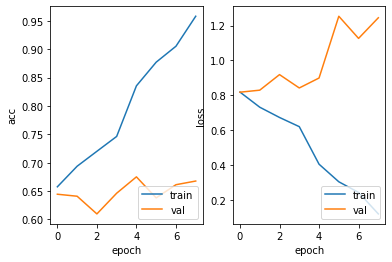

In [23]:
plt.subplot(1,2,1)
plt.plot(history1["accuracy"])
plt.plot(history1["val_accuracy"])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history1["loss"])
plt.plot(history1["val_loss"])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

## Evaluando modelo

In [24]:
%cd drive/MyDrive/pucp/ciclo_05/comp_graf
!unzip test.zip -d ../../../../..
%cd ../../../../..

Streaming output truncated to the last 5000 lines.
  inflating: ../../../../../test/8553adf92deaf5279bcc6f9813c8fdcc_right.jpg  
  inflating: ../../../../../test/856490a8eb25974567e67d4036c3c044_left.jpg  
  inflating: ../../../../../test/856490a8eb25974567e67d4036c3c044_right.jpg  
  inflating: ../../../../../test/8569aad08bd79e68d8a5d2b2ee505408_left.jpg  
  inflating: ../../../../../test/8569aad08bd79e68d8a5d2b2ee505408_right.jpg  
  inflating: ../../../../../test/856b1cacaea25f6ebbf01b0003030a0b_left.jpg  
  inflating: ../../../../../test/856b1cacaea25f6ebbf01b0003030a0b_right.jpg  
  inflating: ../../../../../test/859b00aec8885efc83d1541b52a1220d_left.jpg  
  inflating: ../../../../../test/859b00aec8885efc83d1541b52a1220d_right.jpg  
  inflating: ../../../../../test/85a4413ecea7122bcc399cf0a53bba26_left.jpg  
  inflating: ../../../../../test/85a4413ecea7122bcc399cf0a53bba26_right.jpg  
  inflating: ../../../../../test/85c8395916ffc2198dd670da1b20d108_left.jpg  
  inflating: ../../

In [25]:
model = keras.models.load_model('model.h5')

In [26]:
import os
d = "test"
lista_path = []
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    lista_path.append(full_path)

In [27]:
df = pd.DataFrame({"path": lista_path})
df["ID"] = df["path"].apply(lambda x: x.split("/")[1])
df.head()

,path,ID
0,test/c6b7a3f883ebdc29cbe617ea59b74987_right.jpg,c6b7a3f883ebdc29cbe617ea59b74987_right.jpg
1,test/c9eca6cff4f25c6b73be4bfbd546b1d3_right.jpg,c9eca6cff4f25c6b73be4bfbd546b1d3_right.jpg
2,test/6aa899171430d12d1ed53cc8c02dc3d6_right.jpg,6aa899171430d12d1ed53cc8c02dc3d6_right.jpg
3,test/e02721e864b2649003bcf15ba4da931a_right.jpg,e02721e864b2649003bcf15ba4da931a_right.jpg
4,test/70e57eb7c5b31448a55580c15b574d9c_right.jpg,70e57eb7c5b31448a55580c15b574d9c_right.jpg


In [28]:
test_batches = ImageDataGenerator(rescale = 1./128).flow_from_dataframe(
    dataframe=df,
    directory="test",
    x_col="ID",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(512,512))

Found 10538 validated image filenames.


In [29]:
pred=model.predict(test_batches,
                   verbose=1)

330/330 [==============================] - 153s 450ms/step


In [30]:
predicted_class_indices=np.argmax(pred, axis=1)

In [31]:
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [32]:
filenames=test_batches.filenames
results=pd.DataFrame({"ID": filenames,
                      "level": predictions})

In [33]:
results["ID"] = results["ID"].apply(lambda x: x.split(".")[0])

In [34]:
results.to_csv("submit.csv",index=False)

In [35]:
!unzip modelo.zip -d drive/MyDrive/pucp/ciclo_05/comp_graf/resnet_512

Archive:  modelo.zip
 extracting: drive/MyDrive/pucp/ciclo_05/comp_graf/resnet_512/model.h5  
 extracting: drive/MyDrive/pucp/ciclo_05/comp_graf/resnet_512/history.pkl  


In [ ]:
print("a")